# Comparing Networks

In this notebook, we want to compare different network to each other.
This focuses on...

- Generator Feature Unlearning*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ GeFeU: The implemented algorithm is not the same as the one in the paper. While the paper focused on unlearning specific classes, we are training to unlearn a subset of a class, tied together by a feature, which distinguish it from the rest.

### ! Make sure that Trained, Exact, Untrained Model types are trained !

In [2]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet

from helper import load_models_dict

USED_DATASET = "mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= True,
    test = False,
    classes=["7"],
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

5413

In [3]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [4]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained",
        map_location=DEVICE,
        weights_only=True,
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [5]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [6]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Model

In [7]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    exact_showcase = TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    exact_showcase = ConvNet()
name = str(exact_showcase)
exact_showcase.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [8]:
exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

### Generator Feature Unlearning

In [9]:
from unlearning import unlearn_n_models, GeneratorFeatureUnlearning
from training import save_model

In [10]:
# Train a single model first
if not ALLREADY_TRAINED:
    fefu = GeneratorFeatureUnlearning(
        model=trained_showcase_all,
        dataset_name=USED_DATASET,
    )
    mu_showcase = fefu.unlearn(logs=True)
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}{name}_mu_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [11]:
if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_data,
        dataset_name=USED_DATASET,
        which_unlearning="GeneratorFeatureUnlearning",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [12]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [13]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.640467076996963

In [14]:
# ...unlearned model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

182.55180913209915

In [15]:
# ...exact model
a13 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a13

27.63511853441596

#### Trained to ...

In [16]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

183.31905051867167

In [17]:
# ...exact model
a22 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a22

28.415138625726104

### GeFeU to...

In [18]:
# ...exact model
a31 = calc_mutlimodel_metric_average(mu_ms, exact_ms, metric="l2_norm")
a31

183.39094242254893

#### Exact to ...

In [19]:
# see above

### Layer-wise Distance

In [22]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), mu_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'fc1.weight': 85443.66875,
 'fc1.bias': 158.63890991210937,
 'fc3.weight': 1152.187921142578,
 'fc3.bias': 5.045243088404337}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [12]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [19]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.4299929514558327

#### Trained to...

In [19]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.1746851499372046

#### Exact ...

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

#### MU to...

In [13]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.310664421281565e+204

In [14]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

4.112549022279002e+203

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [13]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'mnist'...


Average accuracy for D_gesamt: 0.8846 - Standard Deviation for D_gesamt: 0.0071


Average accuracy for D_remain: 0.8992 - Standard Deviation for D_remain: 0.0071


Average accuracy for 0: 0.9402 - Standard Deviation for 0: 0.0292


Average accuracy for 1: 0.9613 - Standard Deviation for 1: 0.0123


Average accuracy for 2: 0.8780 - Standard Deviation for 2: 0.0279


Average accuracy for 3: 0.8621 - Standard Deviation for 3: 0.0351


Average accuracy for 4: 0.8720 - Standard Deviation for 4: 0.0362


Average accuracy for 5: 0.8709 - Standard Deviation for 5: 0.0365


Average accuracy for 6: 0.9315 - Standard Deviation for 6: 0.0241


Average accuracy for 8: 0.8980 - Standard Deviation for 8: 0.0291


Average accuracy for 9: 0.8725 - Standard Deviation for 9: 0.0473


Average accuracy for 7_all: 0.7563 - Standard Deviation for 7_all: 0.0680


Average accuracy for 7_remain: 0.8745 - Standard Deviation for 7_remain: 0.0356


Average accuracy for 7_erased: 0.7377 - Standard Deviation for 7_erased: 0.0752
plotting...


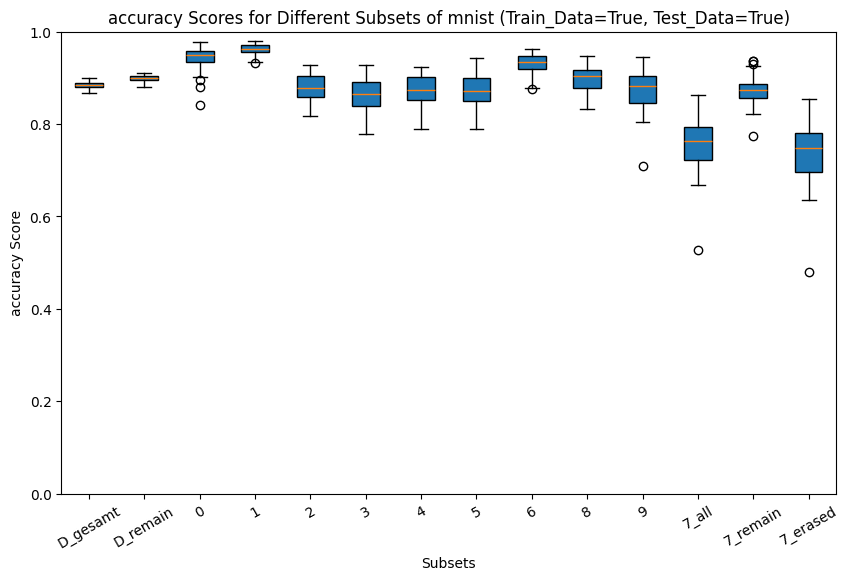

In [14]:
# can take like 80minutes
accs["mu_ms"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="accuracy", logs=True)

#### Losses

In [15]:
losses = {}

Starts evaluation for 'mnist'...


Average loss for D_gesamt: 0.0691 - Standard Deviation for D_gesamt: 0.0090


Average loss for D_remain: 0.0547 - Standard Deviation for D_remain: 0.0064


Average loss for 0: 0.0357 - Standard Deviation for 0: 0.0183


Average loss for 1: 0.0271 - Standard Deviation for 1: 0.0094


Average loss for 2: 0.0672 - Standard Deviation for 2: 0.0183


Average loss for 3: 0.0696 - Standard Deviation for 3: 0.0206


Average loss for 4: 0.0624 - Standard Deviation for 4: 0.0216


Average loss for 5: 0.0635 - Standard Deviation for 5: 0.0181


Average loss for 6: 0.0413 - Standard Deviation for 6: 0.0155


Average loss for 8: 0.0640 - Standard Deviation for 8: 0.0180


Average loss for 9: 0.0650 - Standard Deviation for 9: 0.0251


Average loss for 7_all: 0.1939 - Standard Deviation for 7_all: 0.0845


Average loss for 7_remain: 0.0582 - Standard Deviation for 7_remain: 0.0171


Average loss for 7_erased: 0.2153 - Standard Deviation for 7_erased: 0.0962
plotting...


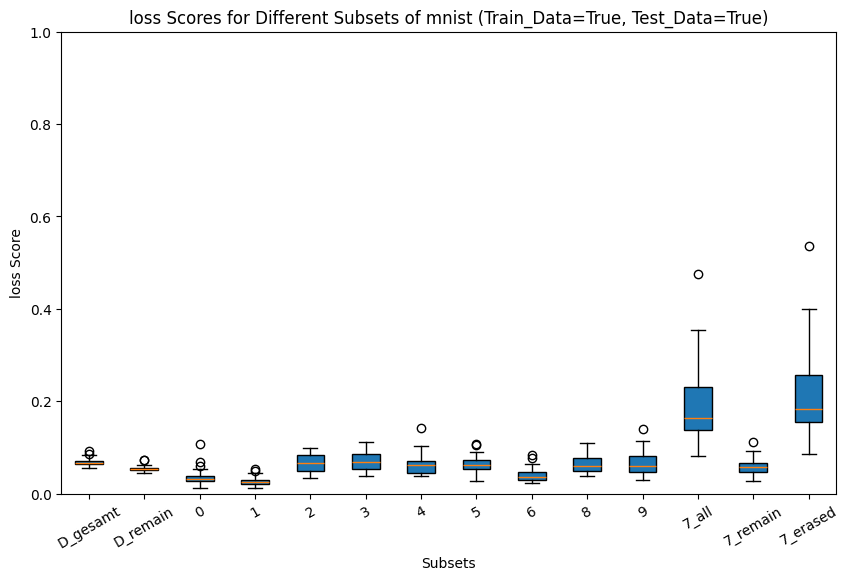

In [16]:
losses["mu_ms"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", logs=True)